In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from PIL import Image

from scripts.preprocessing import scale_range, crop_borders, get_best_rotation

In [2]:
##### EDIT DIRECTORY VARIABLES AS NEEDED
root = "S:/CheXpert"
source_train_folder_name = "CheXpert-v1.0 batch 4 (train 3)"
source_test_folder_name = "CheXpert-v1.0 batch 1 (validate & csv)"

train_filepath = f"{root}/train_data.csv"
test_filepath = f"{root}/test_data.csv"

train_folder_name = "train"
test_folder_name = "test"
train2_folder_name = "train2"
test2_folder_name = "test2"

#####

### Instantiate Variables

# Source: This is where the raw image files are stored (the next level are patient folders)
source_train_root = f"{root}/{source_train_folder_name}/"
source_test_root  = f"{root}/{source_test_folder_name}/valid/"

# These are the output roots for file paths being added to the train/test files
train_root = f"{root}/{train_folder_name}/"
test_root = f"{root}/{test_folder_name}/"
train2_root = f"{root}/{train2_folder_name}/"
test2_root = f"{root}/{test2_folder_name}/"

# This is the original root for the train/test csv files
base_path = "CheXpert-v1.0/train/"


In [3]:
### Load the training/validation csvs
train_df = pd.read_csv(train_filepath)
test_df = pd.read_csv(test_filepath)

print(f"# rows in train_df: {len(train_df)}")
print(f"# rows in test_df: {len(test_df)}")

# rows in train_df: 39371
# rows in test_df: 202


## Preprocessing Steps:

These are performed for both the regular sets

* Scale the image values to the range [0-255]
* Try to crop out any border regions algorithmically
* Resize the training and validation images to 512x512
* Find the 90-degree rotation which is closest to the average of a sample of 1000 x-ray images
* Convert the array to type uint8 for compatibility with Image
* Save the processed image as as jpeg file


In [4]:
### Preprocessing variables

### Value range for scaling image array
scale_min = 0
scale_max = 255
crop_q1_threshold, crop_q3_threshold = np.quantile([i for i in range(scale_min,scale_max)], [0.25, 0.75])

### Desired image dimensions for analysis
image_height = 512
image_width = 512

### Threshold for cropping borders
threshold_range = (scale_max - scale_min) * 0.6

In [5]:
### Find the average training image from a subsample
avg_img_arr = np.zeros((image_height, image_width))

# Online mean computation of a sample of resized and rescaled train X-rays
for i,img_path in enumerate(train_df["source_file_path"].sample(1000), start=1):
    with Image.open(img_path) as img:
        img_arr = np.array(img.resize((image_height, image_width)))
        img_arr = scale_range(img_arr, scale_min, scale_max)
        avg_img_arr = (1 - (1 / i)) * avg_img_arr + (1 / i) * img_arr


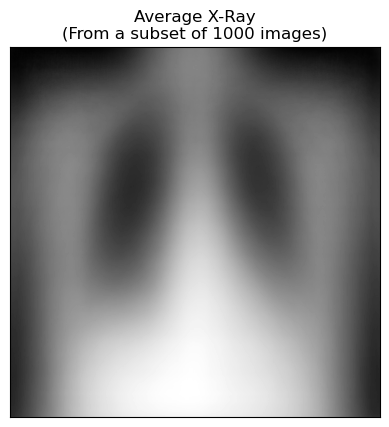

In [6]:
## Visualize the mean image
plt.imshow(Image.fromarray(avg_img_arr.astype(np.uint8)), cmap="gray")
plt.title("Average X-Ray\n(From a subset of 1000 images)")
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
### Preprocessing steps for the regular test set
input_paths = test_df["source_file_path"]
output_paths = test_df["test_file_path"]

for i,(input_file_path, output_file_path) in enumerate(zip(input_paths, output_paths)):
    with Image.open(input_file_path) as img:
        img_arr = np.array(img)
        img_arr = scale_range(img_arr, scale_min, scale_max)
        img_arr = crop_borders(img_arr, threshold_range, crop_q1_threshold, crop_q3_threshold)
        img_arr = np.array(Image.fromarray(img_arr).resize((image_height, image_width)))
        img_arr, dist = get_best_rotation(img_arr, avg_img_arr)
        img = Image.fromarray(img_arr.astype(np.uint8))
        img.save(output_file_path, "JPEG", quality=90)

### (RUN THE BELOW CELL ONCE, MAY TAKE A FEW HOURS)

In [8]:
### Preprocessing steps for the regular training set 
input_paths = train_df["source_file_path"]
output_paths = train_df["train_file_path"]

for i,(input_file_path, output_file_path) in enumerate(zip(input_paths, output_paths)):
    with Image.open(input_file_path) as img:
        img_arr = np.array(img)
        img_arr = scale_range(img_arr, scale_min, scale_max)
        img_arr = crop_borders(img_arr, threshold_range, crop_q1_threshold, crop_q3_threshold)
        img_arr = np.array(Image.fromarray(img_arr).resize((image_height, image_width)))
        img_arr, dist = get_best_rotation(img_arr, avg_img_arr)
        img = Image.fromarray(img_arr.astype(np.uint8))
        img.save(output_file_path, "JPEG", quality=90)